
███████████
█A    █   █
█ ██ ███ ██
█    █    █
████ ██ █B█
█         █
███████████

States explored: 26

███████████
█A    █   █
█*██ ███ ██
█****█    █
████*██ █B█
█   ******█
███████████



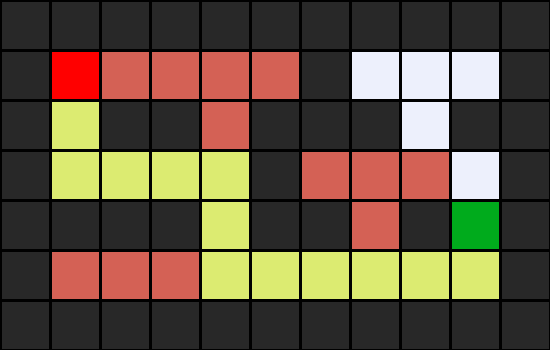

In [2]:
class Node:
    def __init__(self, state, parent, action):  # fixed __init__
        self.state = state
        self.parent = parent
        self.action = action


class StackFrontier:
    def __init__(self):  # fixed __init__
        self.frontier = []

    def add(self, node):
        self.frontier.append(node)

    def contains_state(self, state):
        return any(node.state == state for node in self.frontier)

    def empty(self):
        return len(self.frontier) == 0

    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        node = self.frontier[-1]
        self.frontier = self.frontier[:-1]
        return node


class QueueFrontier(StackFrontier):
    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        node = self.frontier[0]
        self.frontier = self.frontier[1:]
        return node


class Maze:
    def __init__(self, filename):  # fixed __init__
        with open(filename) as f:
            contents = f.read()

        if contents.count("A") != 1:
            raise Exception("maze must have exactly one start point")
        if contents.count("B") != 1:
            raise Exception("maze must have exactly one goal")

        contents = contents.splitlines()
        self.height = len(contents)
        self.width = max(len(line) for line in contents)

        self.walls = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.start = (i, j)
                        row.append(False)
                    elif contents[i][j] == "B":
                        self.goal = (i, j)
                        row.append(False)
                    elif contents[i][j] == " ":
                        row.append(False)
                    else:
                        row.append(True)
                except IndexError:
                    row.append(False)
            self.walls.append(row)

        self.solution = None

    def print(self):
        solution = self.solution[1] if self.solution else None
        print()
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                if col:
                    print("█", end="")
                elif (i, j) == self.start:
                    print("A", end="")
                elif (i, j) == self.goal:
                    print("B", end="")
                elif solution and (i, j) in solution:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()

    def neighbors(self, state):
        row, col = state
        candidates = [
            ("up", (row - 1, col)),
            ("down", (row + 1, col)),
            ("left", (row, col - 1)),
            ("right", (row, col + 1))
        ]
        result = []
        for action, (r, c) in candidates:
            if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
                result.append((action, (r, c)))
        return result

    def solve(self, method="bfs"):
        self.num_explored = 0
        start = Node(state=self.start, parent=None, action=None)
        frontier = QueueFrontier() if method.lower() == "bfs" else StackFrontier()
        frontier.add(start)
        self.explored = set()

        while True:
            if frontier.empty():
                raise Exception("no solution")
            node = frontier.remove()
            self.num_explored += 1
            if node.state == self.goal:
                actions, cells = [], []
                while node.parent is not None:
                    actions.append(node.action)
                    cells.append(node.state)
                    node = node.parent
                actions.reverse()
                cells.reverse()
                self.solution = (actions, cells)
                return
            self.explored.add(node.state)
            for action, state in self.neighbors(node.state):
                if state not in self.explored and not frontier.contains_state(state):
                    child = Node(state=state, parent=node, action=action)
                    frontier.add(child)

    def output_image(self, filename, show_solution=True, show_explored=False):
        from PIL import Image, ImageDraw
        cell_size, cell_border = 50, 2
        img = Image.new("RGBA",
                        (self.width * cell_size, self.height * cell_size),
                        "black")
        draw = ImageDraw.Draw(img)
        solution = self.solution[1] if self.solution else None
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                if col:
                    fill = (40, 40, 40)
                elif (i, j) == self.start:
                    fill = (255, 0, 0)
                elif (i, j) == self.goal:
                    fill = (0, 171, 28)
                elif solution and show_solution and (i, j) in solution:
                    fill = (220, 235, 113)
                elif solution and show_explored and (i, j) in self.explored:
                    fill = (212, 97, 85)
                else:
                    fill = (237, 240, 252)
                draw.rectangle(
                    [(j * cell_size + cell_border, i * cell_size + cell_border),
                     ((j + 1) * cell_size - cell_border, (i + 1) * cell_size - cell_border)],
                    fill=fill)
        img.save(filename)


# --- SAMPLE USAGE IN JUPYTER ---
sample = """###########
#A    #   #
# ## ### ##
#    #    #
#### ## #B#
#         #
###########"""

with open("maze1.txt", "w") as f:
    f.write(sample)

from IPython.display import Image as IPImage, display

m = Maze("maze1.txt")
m.print()
m.solve(method="bfs")
print("States explored:", m.num_explored)
m.print()
m.output_image("maze.png", show_explored=True)
display(IPImage("maze.png"))
